## Advanced Lane Finding Project

The goals / steps of this project are the following:

1. [Camera Calibration](#calibration)
2. [Distortion Correction](#distortion)
3. [Tranformations To A Binary Image](#transformations)
4. [Perspective Transform](#perspective)
5. Detect lane pixels and fit to find the lane boundary.
5. Determine the curvature of the lane and vehicle position with respect to center.
6. Warp the detected lane boundaries back onto the original image.
7. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---

In [ ]:
rows = 4
cols = len(images)//rows
    
fig=plt.figure(figsize=(200, 200))

fig.add_subplot(rows, cols, i + 1)

## Setup

In [6]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

In [13]:
DEBUG = False
SHOW_IMAGES = False

## Camera Calibration <a name="calibration"></a>

Goal: Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

In [7]:
def calibrate_camera(nx, ny, images, DEBUG = False, SHOW_IMAGES = False):
    
    """
    Calibrate camera using a set of calibration images with chessboards.
    Returns:
        mtx: Camera Matrix
        dist: Distortion coefficients
    """

    # 3-D points: (x, y, z)
    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.


    # Step through the list and search for chessboard corners
    for i in range(0, len(images)):
        
        # Read Image
        img = cv2.imread(images[i])
        
        # Convert to Gray Scale
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
        
        if (DEBUG):
            print(f"Image {images[i]} ({i}/{len(images)}) - Corners Found: {ret}")

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
                   
    # Calibrate Camera using object points and image points
    # ret, mtx, dist, rvecs, tvecs - Ignoring irrelvant outputs for this project
    _, mtx, dist, _, _ = cv2.calibrateCamera(objpoints, imgpoints, 
                                             gray.shape[::-1],None,None)
    
    
    # Return Camera matrix and distortion coefficients
    return mtx, dist

In [ ]:
# Number of Corners
nx = 9
ny = 6

# Make a list of calibration images
calibration_path = './camera_cal/calibration*.jpg'
cal_images = glob.glob(calibration_path)

# Get camera metrix and distortion coefficient
mtx, dist = calibrate_camera(nx, ny, cal_images, DEBUG, SHOW_IMAGES)

## Distortion Correction <a name="distortion"></a>

Goal: Apply a distortion correction to raw images.

In [8]:
def undistort_image(img, mtx, dist):
    
    """
    Undistorts the image after camera calibration.
    Returns:
        img: Undistorted Image
    """
    
    return cv2.undistort(img, mtx, dist, None, mtx)

## Transformation to Binary Image <a name="transformations"></a>
Goal: Use color transforms, gradients, etc., to create a thresholded binary image.

In [9]:
# Helper Functions
def get_gradient(img, vertical_gradient = True, sobel_kernel=3):
    
    # Calculate the gradient
    return cv2.Sobel(gray, cv2.CV_64F, vertical_gradient, not(vertical_gradient))

def scale_mtx_to_8bit(mtx):
    
    scale_factor = np.max(mtx)/255 
    return (mtx/scale_factor).astype(np.uint8) 

def apply_thresholds(mtx, threshold=(0,255), scale = False):
    
    # Scale the matrix to 8-bits
    base = scale_mtx_to_8bit(mtx) if scale else mtx

    # Prepare a binary matrix of equal size to the base
    binary = np.zeros_like(base)
    
    # Apply thresholds - "Activate" pixels that meet criteira
    binary[(base >= threshold[0]) & (base <= threshold[1])] = 1
    
    return binary

In [22]:
# Gradient
def apply_gradient_thresholds(gradient, threshold=(0,255)):
    
    # Get the absolute gradient
    abs_sobel = np.absolute(gradient)
    
    # Apply thresholds in a binary matrix
    return apply_thresholds(abs_sobel, threshold, scale = True)

# Magnitude
def apply_magnitude_thresholds(gradient_x, gradient_y, threshold=(0, 255)):
    
    # Calculate the gradient magnitude
    magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
    
    # Apply thresholds in a binary matrix
    return apply_thresholds(magnitude, threshold, scale = True)

# Direction
def apply_direction_thresholds(gradient_x, gradient_y, threshold=(0, np.pi/2)):
    
    # Take the absolute value of the gradient direction, 
    
    abs_gradient_direction = np.arctan2(np.absolute(gradient_y), np.absolute(gradient_x))
    
    # Apply thresholds in a binary matrix
    return apply_thresholds(abs_gradient_direction, threshold)

In [55]:
# Gradient Pipeline
def apply_gradient_pipeline(img):

    # Calculate the gradient
    sobel_x = get_gradient(img, True)
    sobel_y = get_gradient(img, False)

    gradient_x_mask = apply_gradient_thresholds(sobel_x, threshold = (10,150))
    direction_mask = apply_direction_thresholds(sobel_x, sobel_y, threshold = (20*np.pi/180, 70*np.pi/180))
    magnitude_mask = apply_magnitude_thresholds(sobel_x, sobel_y, threshold = (30, 100))
    
    combined = np.zeros_like(direction_mask)
    combined[(gradient_x_mask == 1) | ((magnitude_mask == 1) & (direction_mask == 1))] = 1
    
    return combined

In [167]:
# Color
def apply_red_threshold(img, threshold = (0, 255)):
    
    R = img[:,:,0]
    return apply_thresholds(R, threshold)

def apply_saturation_threshold(img, threshold = (0, 255)):
    
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    S = hls[:,:,2]
    return apply_thresholds(S, threshold)

def apply_color_pipeline(img):
    
    R_mask = apply_red_threshold(img, (210,255))
    S_mask = apply_saturation_threshold(img, (90, 255))
    
    combined = np.zeros_like(S_mask)
    combined[(R_mask == 1) & (S_mask == 1)] = 1
    
    return combined

In [187]:
def get_thresholded_image(img):
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    gradient_masks = apply_gradient_pipeline(gray)
    color_masks = apply_color_pipeline(img)
    
    combined = np.zeros_like(color_masks)
    combined[(gradient_masks == 1) | (color_masks == 1)] = 1
    
    return combined

In [191]:
img = mpimg.imread(test_images[1]) 

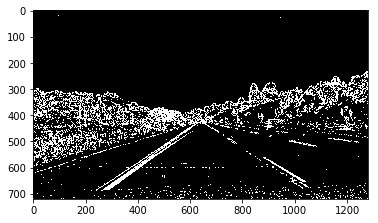

In [192]:
plt.imshow(get_thresholded_image(img), cmap='gray')

## Perspective Transform <a name="perspective"></a>
Goal: Apply a perspective transform to rectify binary image ("birds-eye view").

In [ ]:
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

# Final Pipeline

In [76]:
# Make a list of calibration images
test_image_path = './test_images/*.jpg'
test_images = glob.glob(test_image_path)

In [50]:
for fname in test_images:
    
    img = mpimg.imread(fname) 
    processed_image = undistort_image(img, mtx, dist)
    
    processed_image = get_thresholded_image(processed_image)

NameError: name 'test_images' is not defined